In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyRegressor

import scipy.stats as stats

from ts_utils import OOSR2

In [2]:
df = pd.read_csv("../_data/time_series.csv", index_col="Date")
df.index = pd.to_datetime(df.index)
df = df.round(4)

train = df.loc[df.index <= "2009.12.31"]
test = df.loc[df.index > "2009.12.31"]

train.shape, test.shape

((357, 52), (158, 52))

In [7]:
bestparams = []
predictions = []
naive_predictions = []
train_end_dates = []

naive_mean = DummyRegressor(strategy="mean")

for i in np.arange(357,515,6): 
    train_realtime = df.iloc[:i]
    test_realtime = df.iloc[i:i+6]
    
    X_train, y_train = train_realtime.drop(["EXCESS_RETURN_T+1"], axis=1).values, train_realtime["EXCESS_RETURN_T+1"].values
    X_test, y_test = test_realtime.drop(["EXCESS_RETURN_T+1"], axis=1).values, test_realtime["EXCESS_RETURN_T+1"].values
    
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ("pca", PCA()),
        ('regressor', LinearRegression(positive=True))
    ])

    param_grid = {
        "pca__n_components": [i for i in np.arange(1,3)] 
    }

    tscv = TimeSeriesSplit(n_splits=2)

    grid_search = GridSearchCV(
        estimator=pipeline, 
        param_grid = param_grid,
        scoring="neg_mean_squared_error",
        refit= "neg_mean_squared_error", 
        cv=tscv,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    naive_mean.fit(X_train, y_train)

    predictions.extend(grid_search.predict(X_test).tolist())
    naive_predictions.extend(naive_mean.predict(X_test).tolist())
    train_end_dates.append(pd.to_datetime(train_realtime.index[-1]).strftime('%Y-%m-%d'))
    bestparams.append(grid_search.best_params_)
    
    best = grid_search.best_estimator_
    print(best.named_steps["pca"].explained_variance_)

[0.79498461]
[0.80312812 0.2253927 ]
[0.80337683]
[0.80080942]
[0.8000856]
[0.79492003]
[0.79334624 0.22748903]
[0.79079338]
[0.79456935]
[0.79808332]
[0.80495982]
[0.8042789]
[0.80082225]
[0.79647057]
[0.79579969]
[0.79420021]
[0.79228415]
[0.78808874]
[0.78459932]
[0.79076901]
[0.7895652]
[0.78780149]
[0.7914928  0.21833777]
[0.78927616 0.21881641]
[0.79520367 0.21716212]
[0.79676257]
[0.80481952]


In [8]:
OOSR2(test["EXCESS_RETURN_T+1"].values, np.array(predictions), np.array(naive_predictions))

0.028893060057178954

[]

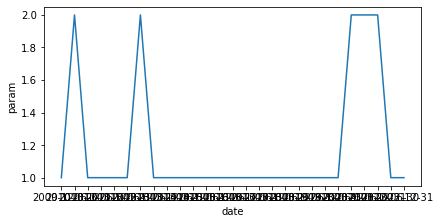

In [9]:
nlist = []

for paramdict in bestparams:
    nlist.append(paramdict["pca__n_components"])
    
fig, ax = plt.subplots(figsize=(6,3), constrained_layout=True)
ax.plot(train_end_dates, nlist)
ax.set_xlabel('date')
ax.set_ylabel('param')

plt.plot()

In [10]:
rfr = pd.read_csv("../_data/rfr_02_2010_to_03_2023_158vals.csv", index_col="Date")
econeval = pd.DataFrame()
econeval["r"] = test["EXCESS_RETURN_T+1"]
econeval["r_predict"] = predictions
econeval["mean_predict"] = naive_predictions
econeval["rfr"] = rfr["RF"].values
econeval.index = rfr.index
econeval["vola_est"] = econeval["r"].rolling(window=12, closed="left").std()
econeval["w_model"] = 1/3*econeval["r_predict"]/econeval["vola_est"]**2
econeval["w_mean"] = 1/3*econeval["mean_predict"]/econeval["vola_est"]**2
econeval["w_model_cap"] = econeval["w_model"].apply(lambda x: 1 if x > 1 else (0 if x < 0 else x))
econeval["w_mean_cap"] = econeval["w_mean"].apply(lambda x: 1 if x > 1 else (0 if x < 0 else x))
econeval["rp_model"] = econeval["rfr"]+econeval["w_model_cap"]*econeval["r"]
econeval["rp_mean"] = econeval["rfr"]+econeval["w_mean_cap"]*econeval["r"]

In [11]:
econeval.dropna(axis=0,inplace=True)
u_model = econeval["rp_model"].mean() - 0.5*3*econeval["rp_mean"].std()**2
u_mean = econeval["rp_mean"].mean() - 0.5*3*econeval["rp_mean"].std()**2
annualized_gain = (u_model - u_mean)*12
monthly_sharpe = econeval["rp_model"].mean() / econeval["rp_model"].std()
sp500meanreturn = econeval["r"].mean()
sp500vol = econeval["r"].std()

print("annualized gain: ", annualized_gain)
print("monthly avg portfolio return: ", econeval["rp_model"].mean())
print("monthly volatility: ", econeval["rp_model"].std())
print("monthly sharpe: ", monthly_sharpe)
print("sp500 mean return:",sp500meanreturn)
print("sp500 vola:",sp500vol)

annualized gain:  0.018471122088048762
monthly avg portfolio return:  0.00721877003925327
monthly volatility:  0.03300267346175605
monthly sharpe:  0.21873288682562275
sp500 mean return: 0.008317123287671233
sp500 vola: 0.0419887429242304


In [6]:
best = grid_search.best_estimator_
best.named_steps["pca"].explained_variance_

array([0.80481952])

In [ ]:
# Equal to n_components largest eigenvalues of the covariance matrix of X.